### Explore PCA for just the Proestou & Sullivan studies, starting with just 2023

In [ ]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


working_dir = "~/git/Cvirg_Pmarinus_RNAseq/data/"
# === 1️⃣ Load Expression Data (TSV) ===
expression_file = os.path.join(working_dir, "rnaseq_gene_counts", "merged_gene_counts.tsv")
expression_df = pd.read_csv(expression_file, sep="\t")

# Load the metadata file
metadata_file_path = os.path.join(working_dir, "augmented_metadata.csv")
metadata_df = pd.read_csv(metadata_file_path)
display(metadata_df.head())

# Extract unique BioProject values along with their associated Study values
unique_bioprojects = metadata_df[['BioProject', 'Study']].drop_duplicates()

# Filter the metadata for the selected BioProjects
# selected_bioprojects = ["PRJNA894694", "PRJNA691949", "PRJNA590205"]
selected_bioprojects = ["PRJNA691949", "PRJNA590205"]
filtered_metadata = metadata_df[metadata_df["BioProject"].isin(selected_bioprojects)]

# Extract the corresponding Experiment IDs (sample IDs)
selected_experiments = filtered_metadata["Experiment"].unique()

# Subset the gene counts data to include only the selected Experiment IDs
filtered_gene_counts = expression_df[['gene_id'] + list(selected_experiments)]

,Study,BioProject,Experiment,BREED,treatment,control,Trait,tissue,Collection_Interval_Days,Collection_Date,subset,TRSS
0,P&S 2023,PRJNA894694,SRX18040064,ABC_VIMS_Family_2017084,Dose 1x10^6,0,tolerant,mantle,7.0,2018-06-20,0.0,tolerant
1,P&S 2023,PRJNA894694,SRX18040063,ABC_VIMS_Family_2017084,Control,1,tolerant,mantle,7.0,2018-06-20,1.0,tolerant
2,P&S 2023,PRJNA894694,SRX18040062,ABC_VIMS_Family_2017120,Dose 1x10^6,0,sensitive,mantle,7.0,2018-06-20,0.0,sensitive
3,P&S 2023,PRJNA894694,SRX18040061,ABC_VIMS_Family_2017120,Dose 1x10^8,0,sensitive,mantle,7.0,2018-06-20,1.0,sensitive
4,P&S 2023,PRJNA894694,SRX18040060,ABC_VIMS_Family_2017090,Dose 1x10^6,0,sensitive,mantle,7.0,2018-06-20,0.0,sensitive


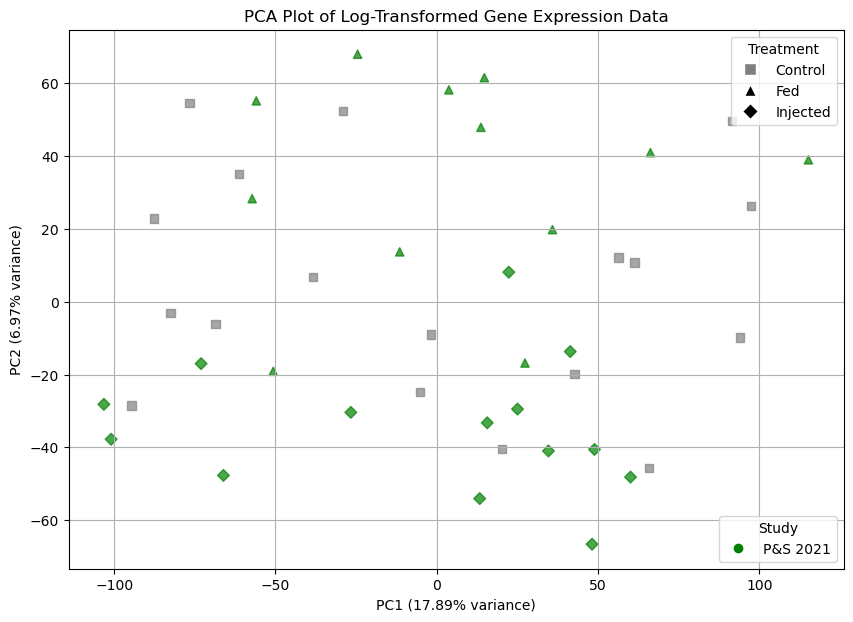

In [9]:
# Transpose the dataframe so that samples are rows and genes are columns
gene_expression_matrix = filtered_gene_counts.set_index("gene_id").T

# Log-transform the gene expression data (log2(x + 1) transformation)
log_gene_expression_matrix = np.log2(gene_expression_matrix + 1)

# === 4️⃣ Select Top 5000 Most Variable Genes ===
top_genes = log_gene_expression_matrix.var().nlargest(5000).index
log_gene_expression_matrix_subset = log_gene_expression_matrix[top_genes]

# Perform PCA on log-transformed, subsetted, standardized data
pca_log = PCA(n_components=2)
principal_components = pca_log.fit_transform(log_gene_expression_matrix_subset)

# Compute explained variance ratios
explained_variance_log = pca_log.explained_variance_ratio_ * 100

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(principal_components, columns=["PC1", "PC2"], index=log_gene_expression_matrix.index)

# Merge with metadata to include Study and treatment information
pca_df = pca_df.merge(metadata_df[["Experiment", "Study", "treatment"]], left_index=True, right_on="Experiment")

# Define colors for different studies
study_colors = {
    "P&S 2023": plt.cm.Blues,  # Shades of blue for P&S 2023
    "P&S 2021": "green",  # Green for P&S 2021
    "P&S 2020": "red",  # Red for P&S 2020
}

# Assign colors to each sample individually
sample_colors = {}

# Extract unique dose levels in sorted order for a smoother gradient
dose_samples = pca_df[pca_df["Study"] == "P&S 2023"]["treatment"].unique()
dose_levels = sorted([t for t in dose_samples if "Dose" in t], key=lambda x: x)
dose_shades = [plt.cm.Blues(i) for i in np.linspace(0.2, 0.9, len(dose_levels))]  # Distinct shades of blue
dose_color_map = {dose_levels[i]: dose_shades[i] for i in range(len(dose_levels))}

# Assign colors based on Study and Treatment
for _, row in pca_df.iterrows():
    if "Control" in row["treatment"]:
        sample_colors[row["Experiment"]] = "gray"  # Override everything if it's Control
    elif row["Study"] == "P&S 2023" and "Dose" in row["treatment"]:
        sample_colors[row["Experiment"]] = dose_color_map.get(row["treatment"], "blue")  # Assign shade of blue for dose
    else:
        sample_colors[row["Experiment"]] = study_colors.get(row["Study"], "black")  # Assign fixed study colors

# Define marker styles for different treatment categories
marker_map = {
    "Control": "s",  # Squares for Control
    "Injected": "D",  # Diamonds for Injected
    "Fed": "^",  # Triangles for Fed
}
default_marker = "o"  # Circles for Dose treatments

# Assign marker styles based on treatment type
treatment_marker_map = {t: marker_map.get(t.split()[0], default_marker) for t in pca_df["treatment"].unique()}

# Create the PCA plot for log-transformed data
plt.figure(figsize=(10, 7))

for study in pca_df["Study"].unique():
    for treat in pca_df["treatment"].unique():
        subset = pca_df[(pca_df["Study"] == study) & (pca_df["treatment"] == treat)]
        if not subset.empty:
            plt.scatter(subset["PC1"], subset["PC2"], 
                        color=[sample_colors[exp] for exp in subset["Experiment"]], marker=treatment_marker_map[treat], 
                        label=f"{study} - {treat}", alpha=0.7)

# Axis labels with explained variance
plt.xlabel(f"PC1 ({explained_variance_log[0]:.2f}% variance)")
plt.ylabel(f"PC2 ({explained_variance_log[1]:.2f}% variance)")
plt.title("PCA Plot of Log-Transformed Gene Expression Data")

# Sort treatments for the legend (ensuring "Control" appears first)
sorted_treatments = sorted(pca_df["treatment"].unique(), key=lambda x: ("Control" not in x, x))

# Create a sorted legend for treatments (using different shapes and colors)
legend_elements_treatment = [
    plt.Line2D([0], [0], marker=treatment_marker_map[t], color='w', 
               markerfacecolor="gray" if "Control" in t else "black", markersize=8, label=t)
    for t in sorted_treatments
]

# Generate the sorted treatment legend
legend_treatment = plt.legend(handles=legend_elements_treatment, title="Treatment", loc="upper right")

# Create a separate legend for Study colors
legend_elements_study = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=study_colors[s] if isinstance(study_colors[s], str) else "blue", markersize=8, label=s)
    for s in pca_df["Study"].unique()
]
legend_study = plt.legend(handles=legend_elements_study, title="Study", loc="lower right")

# Add legends to the plot
plt.gca().add_artist(legend_treatment)

plt.grid(True)
plt.show()